##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural machine translation with attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation. This is an advanced example that assumes some knowledge of sequence to sequence models.

After training the model in this notebook, you will be able to input a Spanish sentence, such as *"¿todavia estan en casa?"*, and return the English translation: *"are you still at home?"*

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: This example takes approximately 10 minutes to run on a single P100 GPU.

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
print("imported all")

imported all


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

There are a variety of languages available, but we'll use the English-Spanish dataset. For convenience, we've hosted a copy of this dataset on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps we'll take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [2]:
# Download the file
# path_to_zip = tf.keras.utils.get_file(
#     'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
#     extract=True)

# path_to_german_file = os.path.curdir+"/../data/europol-v7.de-en.de"

# path_to_english_file = os.path.curdir+"/../data/europol-v7.de-en.en"
# print(path_to_german_file)

# path_to_german_file = "C:/users/justi/Documents/RDPTranslation/initalTest/data/europarl-v7.de-en.de"

# path_to_english_file = "C:/users/justi/Documents/RDPTranslation/initalTest/data/europarl-v7.de-en.en"

path_to_german_file = "E:/RDPTranslation/initalTest/data/europarl-v7.de-en.de"

path_to_english_file = "E:/RDPTranslation/initalTest/data/europarl-v7.de-en.en"

print(path_to_german_file)

E:/RDPTranslation/initalTest/data/europarl-v7.de-en.de


In [3]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [8]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [4]:
def join_sentences(english_data, german_data):
      germ_lines = io.open(german_data, encoding='UTF-8').read().strip().split('\n')
      eng_lines = io.open(english_data, encoding='UTF-8').read().strip().split('\n')
      german_result= []
      english_result = []
      combined_data = []
      for i in range (1,30000): ## only run on first 30k lines
        german_lines_clean = preprocess_sentence(germ_lines[i])
        english_lines_clean = preprocess_sentence(eng_lines[i])
        combined_data.append(english_lines_clean)
#         combined_data.append('\t')
        combined_data.append(german_lines_clean)
        german_result.append(german_lines_clean)
        english_result.append(english_lines_clean)
      return combined_data, german_result, english_result
data, german_data, english_data = join_sentences(path_to_english_file,path_to_german_file)

In [5]:
print(len(data))
# data = data.strip('\t')
x = data[0::1]
print(len(x))

# for i in range(5):
#     print(x[i])
# print(data[3])
# print(x[3])
# print(german_data[0])
print(len(german_data))
# print(german_data)
print(english_data[0])

59998
59998
29999
<start> i declare resumed the session of the european parliament adjourned on friday december , and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period . <end>


In [6]:
joined_data = ['\t'.join(x) for x in zip(data[0::2], x[1::2])]
print(joined_data[0])
# print(len(joined_data))
print(english_data[-1])

<start> i declare resumed the session of the european parliament adjourned on friday december , and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period . <end>	<start> ich erklare die am freitag , dem . dezember unterbrochene sitzungsperiode des europaischen parlaments fur wiederaufgenommen , wunsche ihnen nochmals alles gute zum jahreswechsel und hoffe , da sie schone ferien hatten . <end>
<start> we hope that this amendment will be adopted . <end>


In [6]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [9]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

NameError: name 'path_to_file' is not defined

In [7]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,dtype='float32', maxlen=179,
                                                         padding='post')

  return tensor, lang_tokenizer

In [8]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
#   targ_lang, inp_lang = create_dataset(path, num_examples)
  
  input_tensor, inp_lang_tokenizer = tokenize(english_data)
  target_tensor, targ_lang_tokenizer = tokenize(german_data)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [9]:
input_tensor, inp_lang_tokenizer = tokenize(english_data)
target_tensor, targ_lang_tokenizer = tokenize(german_data)
print(input_tensor.shape)
# print(len(inp_lang_tokenizer))
print(target_tensor.shape)
# print(len(targ_lang_tokenizer))

(29999, 179)
(29999, 179)


### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [10]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_english_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [11]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

23999 23999 6000 6000


In [12]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [13]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
4 ----> <start>
377 ----> allow
172 ----> me
7 ----> to
1252 ----> emphasise
12 ----> that
13 ----> this
11 ----> is
3814 ----> communitisation
2 ----> ,
23 ----> not
4166 ----> renationalisation
2 ----> ,
6 ----> of
265 ----> competition
257 ----> law
3 ----> .
5 ----> <end>

Target Language; index to word mapping
4 ----> <start>
80 ----> dies
16 ----> ist
1 ----> ,
25 ----> mit
9170 ----> verlaub
267 ----> gesagt
1 ----> ,
22 ----> eine
10837 ----> vergemeinschaftlichung
21 ----> des
7211 ----> wettbewerbsrechts
7 ----> und
18 ----> nicht
370 ----> dessen
4834 ----> renationalisierung
3 ----> .
5 ----> <end>


### Create a tf.data dataset

In [14]:
BUFFER_SIZE = len(input_tensor_train)
# BATCH_SIZE = 64
## for custom model use
BATCH_SIZE = 179
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [15]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([179, 179]), TensorShape([179, 179]))

## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [21]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [22]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (179, 179, 1024)
Encoder Hidden state shape: (batch size, units) (179, 1024)


In [23]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [24]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (179, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (179, 179, 1)


In [25]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [26]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (179, 35384)


## Define the optimizer and the loss function

In [16]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(clipnorm=1,learning_rate=lr_schedule)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
## Checkpoints (Object-based saving)

In [24]:
checkpoint_dir = './models/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [25]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [30]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

ValueError: in user code:

    <ipython-input-25-49d4266c745b>:6 train_step  *
        enc_output, enc_hidden = encoder(inp, enc_hidden)
    <ipython-input-17-d84b3d8301ef>:14 call  *
        output, state = self.gru(x, initial_state = hidden)
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:707 __call__  **
        return super(RNN, self).__call__(inputs, **kwargs)
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\layers\recurrent_v2.py:438 call
        inputs, initial_state, training, mask, row_lengths)
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\layers\recurrent_v2.py:500 _defun_gru_call
        **normal_gru_kwargs)
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\layers\recurrent_v2.py:789 gru_with_backend_selection
        last_output, outputs, new_h, runtime = defun_standard_gru(**params)
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\eager\function.py:2419 __call__
        graph_function, args, kwargs = self._maybe_define_function(args, kwargs)
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\eager\function.py:2777 _maybe_define_function
        graph_function = self._create_graph_function(args, kwargs)
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\eager\function.py:2667 _create_graph_function
        capture_by_value=self._capture_by_value),
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\func_graph.py:981 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\layers\recurrent_v2.py:586 standard_gru
        zero_output_for_mask=zero_output_for_mask)
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\backend.py:4092 rnn
        input_time_zero, tuple(initial_states) + tuple(constants))
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\layers\recurrent_v2.py:568 step
        z = recurrent_activation(x_z + recurrent_z)
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\math_ops.py:984 binary_op_wrapper
        return func(x, y, name=name)
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\math_ops.py:1276 _add_dispatch
        return gen_math_ops.add_v2(x, y, name=name)
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:483 add_v2
        "AddV2", x=x, y=y, name=name)
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\func_graph.py:595 _create_op_internal
        compute_device)
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py:3327 _create_op_internal
        op_def=op_def)
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py:1817 __init__
        control_input_ops, op_def)
    c:\users\justi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 179 and 64 for '{{node add}} = AddV2[T=DT_FLOAT](split, split_1)' with input shapes: [179,1024], [64,1024].


In [19]:
def buildModel():
    model = tf.keras.Sequential(layers=[
        # tf.keras.layers.LSTM(64),
        # tf.keras.layers.LSTM(16),
#         tf.keras.layers.Conv1D(668,kernel_size=1),
        tf.keras.layers.Conv1D(127,kernel_size=1),
        tf.keras.layers.Conv1D(64,kernel_size=1),
        tf.keras.layers.Conv1D(16,kernel_size=1),
#         tf.keras.layers.Flatten(),
        # tf.keras.layers.Conv1D(64,kernel_size=1), #input_shape=(64,668)
        # tf.keras.layers.MaxPool1D(),
        # tf.keras.layers.Conv1D(16,kernel_size=1),
        # tf.keras.layers.Dense(16),
        # # # tf.keras.layers.MaxPool1D(),
        # #
        tf.keras.layers.Dense(16),
#         tf.keras.layers.Dense(128),
#         tf.keras.layers.Dense(668),
        tf.keras.layers.Dense(501318)

        # tf.keras.layers.Conv1DTranspose(1,kernel_size=1),
        # tf.keras.layers.Conv1DTranspose(668,kernel_size=1)

        ])
    return model


# seq2seq.summary()

with tf.device('/cpu:0'): ## comment out to run on gpu
    start_time = time.time()
    seq2seq = buildModel()
    print("Time required to create model --- %s seconds ---" % (time.time() - start_time))

    ## Train model and print results
    seq2seq.compile(optimizer= 'adam',loss=loss_function)
    seq2seq.build(input_shape=(668,64,1))
    # seq2seq.summary()


    start_time = time.time()
    for (batch, (inp, targ)) in enumerate(dataset.take(32)):
        inp = tf.reshape(inp,[inp.shape[0],inp.shape[1],1])
        targ = tf.reshape(targ,[targ.shape[0],targ.shape[1],1])
        seq2seq.train_on_batch(x=inp,y=targ)
        print(batch)
        print("Time taken to train batch: %s", time.time()-start_time)
    #     print(targ.shape)
    #     seq2seq.fit(x=input_tensor_train,y=target_tensor_train,epochs=10)
    seq2seq.summary()
    seq2seq.save(filepath="./models/dense")

Time required to create model --- 0.01900029182434082 seconds ---


In [17]:
def buildModel():
    model = tf.keras.Sequential(layers=[
        # tf.keras.layers.LSTM(64),
        # tf.keras.layers.LSTM(16),
#         tf.keras.layers.Conv1D(668,kernel_size=1),
        tf.keras.layers.Conv1D(179,kernel_size=1),
        tf.keras.layers.Conv1D(64,kernel_size=1),
        tf.keras.layers.Conv1D(16,kernel_size=1),
#         tf.keras.layers.Flatten(),
        # tf.keras.layers.Conv1D(64,kernel_size=1), #input_shape=(64,668)
        # tf.keras.layers.MaxPool1D(),
        # tf.keras.layers.Conv1D(1,kernel_size=1),
        # tf.keras.layers.Dense(16),
        # # # tf.keras.layers.MaxPool1D(),
        # #
        tf.keras.layers.Dense(16),
        tf.keras.layers.Dense(64),
        tf.keras.layers.Dense(179),
        tf.keras.layers.Dense(668),
        # tf.keras.layers.Dense(668),
        # tf.keras.layers.Dense(668),
        # tf.keras.layers.Dense(4295821)

        # tf.keras.layers.Conv1DTranspose(1,kernel_size=1),
        # tf.keras.layers.Conv1DTranspose(668,kernel_size=1)

        ])
    return model
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


# seq2seq.summary()

# with tf.device('/cpu:0'): ## comment out to run on gpu
#     start_time = time.time()
#     seq2seq = buildModel()
#     print("Time required to create model --- %s seconds ---" % (time.time() - start_time))

#     ## Train model and print results
#     seq2seq.compile(optimizer= 'adam',loss=loss_function)
#     seq2seq.build(input_shape=(668,64,1))
#     # seq2seq.summary()
#     start_time = time.time()
#     for (batch, (inp, targ)) in enumerate(dataset.take(32)):
#         inp = tf.reshape(inp,[inp.shape[0],inp.shape[1],1])
#         targ = tf.reshape(targ,[targ.shape[0],targ.shape[1],1])
#         seq2seq.train_on_batch(x=inp,y=targ)
#         print(batch)
#         print("Time taken to train batch: %s", time.time()-start_time)
#     #     print(targ.shape)
#     #     seq2seq.fit(x=input_tensor_train,y=target_tensor_train,epochs=10)
#     seq2seq.summary()
#     seq2seq.save(filepath="./models/dense")
start_time = time.time()
seq2seq = buildModel()
print("Time required to create model --- %s seconds ---" % (time.time() - start_time))
## Train model and print results

### Loss functions
## MSE gives high error
## SparseCategoricalCrossentropy gives nan
## loss_function gives shape error
## sparse_categorical_crossentropy give shape error
print("y train")
print(target_tensor_train.shape)
print("Y val")
print(target_tensor_val.shape)

def loss_function(y_pred, y):
   
    #shape of y [batch_size, ty]
    #shape of y_pred [batch_size, Ty, output_vocab_size] 
    sparsecategoricalcrossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                                                  reduction='none')
    loss = sparsecategoricalcrossentropy(y_true=y, y_pred=y_pred)
    mask = tf.logical_not(tf.math.equal(y,0))   #output 0 for y=0 else output 1
    mask = tf.cast(mask, dtype=loss.dtype)
    loss = mask* loss
    loss = tf.reduce_mean(loss)
    return loss
seq2seq.compile(optimizer=optimizer,loss='mean_squared_logarithmic_error',metrics= ['accuracy'])
seq2seq.build(input_shape=(668,64,1))
# seq2seq.summary()
start_time = time.time()
seq2seq.summary()

for (batch, (inp, targ)) in enumerate(dataset.take(64)):
    inp = tf.reshape(inp,[inp.shape[0],inp.shape[1],1])
    targ = tf.reshape(targ,[targ.shape[0],targ.shape[1],1])

    loss = seq2seq.train_on_batch(x=inp,y=targ)
    print(batch)
    print("Time taken to train batch: %s", time.time()-start_time)
    print("batch loss: %f", loss)
    print(targ.shape)
    seq2seq.fit(x=inp,y=targ,epochs=5)
seq2seq.save(filepath="./models/nmt")    

 - 0s 10ms/step - loss: 1.9504 - accuracy: 1.5605e-04
Epoch 3/5
6/6 [==============================] - 0s 8ms/step - loss: 1.9452 - accuracy: 0.0000e+00
Epoch 4/5
6/6 [==============================] - 0s 9ms/step - loss: 1.9444 - accuracy: 3.1210e-05
Epoch 5/5
6/6 [==============================] - 0s 10ms/step - loss: 1.9426 - accuracy: 6.2420e-05
33
Time taken to train batch: %s 16.386844873428345
batch loss: %f [2.0681111812591553, 6.24200256424956e-05]
(179, 179, 1)
Epoch 1/5
6/6 [==============================] - 0s 10ms/step - loss: 2.1955 - accuracy: 6.2420e-05
Epoch 2/5
6/6 [==============================] - 0s 9ms/step - loss: 2.1945 - accuracy: 6.2420e-05
Epoch 3/5
6/6 [==============================] - 0s 10ms/step - loss: 2.1951 - accuracy: 5.6178e-04
Epoch 4/5
6/6 [==============================] - 0s 8ms/step - loss: 2.1959 - accuracy: 3.1210e-05
Epoch 5/5
6/6 [==============================] - 0s 11ms/step - loss: 2.1976 - accuracy: 2.4968e-04
34
Time taken to train bat

In [18]:
# temp = []
# temp2 = []
for (batch, (inp, targ)) in enumerate(dataset.take(32)):
    inp = tf.reshape(inp,[inp.shape[0],inp.shape[1],1])
    targ = tf.reshape(targ,[targ.shape[0],targ.shape[1],1])
#     seq2seq.train_on_batch(x=inp,y=targ)
# #     print(targ.shape)
#     temp.append(inp)
#     temp2.append(targ)
# print(len(temp))
# print(input_tensor_train.shape)
# input_tensor_train = tf.reshape(input_tensor_train,[input_tensor_train.shape[0],input_tensor_train.shape[1],1])
# print(input_tensor_train.shape)
# target_tensor_train = tf.reshape(target_tensor_train,[target_tensor_train.shape[0],target_tensor_train.shape[1],1])
# print(target_tensor_train.shape)

# # # samp_in, samp_targ = dataset.shuffle(5000).batch(1)

NameError: name 'seq2seq' is not defined

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [22]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [23]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [24]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [35]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> this is <end>
Predicted translation: belassen nissan ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdrucken ausdruck

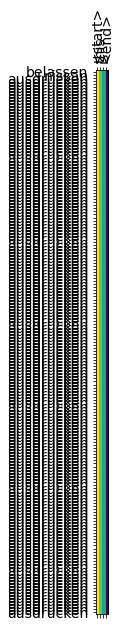

In [72]:
translate(u'this is')

## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs


In [20]:
for (batch, (inp, targ)) in enumerate(dataset.take(32)):
    inp = tf.reshape(inp,[inp.shape[0],inp.shape[1],1])
    targ = tf.reshape(targ,[targ.shape[0],targ.shape[1],1])
    predictions = []
    predictions.append(seq2seq.predict_on_batch(inp))
    german_output = ge_tokenizer.sequences_to_texts(predictions[0][batch-1])
    string_output = " "
    # string_output = string_output.join(german_output)
    # print(string_output)
    while("" in german_output) : 
        german_output.remove('')
    print(german_output)
    # print(predictions)
# print(predictions[0])
results = predictions[0]
# german_output = ge_tokenizer.sequences_to_texts(results)
# print(results.shape)
# print(results[1][1])
# output = results[1][1]

['parlament']
['leuten']
[]
[]
[]
['erweisen']
[]
[]
[]
[]
[]
['vermeiden']
['syrien', 'mehrere']
[]
[]
[]
[]
['einfuhrt', 'palmol erdolgesellschaft']
[]
[]
[]
[]
[]
['angrenzenden elles']
['spanischen', 'gefahr']
['haus']
['aufmerksamkeit']
[]
['augen']
[]
[]
[]


In [26]:
output = seq2seq.evaluate(x=input_tensor_val, y=target_tensor_val,verbose=2)

print(output[1])

ValueError: in user code:

    C:\Users\justi\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\keras\engine\training.py:941 test_function  *
        outputs = self.distribute_strategy.run(
    C:\Users\justi\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\justi\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\justi\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\justi\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\keras\engine\training.py:909 test_step  **
        y_pred = self(x, training=False)
    C:\Users\justi\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:886 __call__
        self.name)
    C:\Users\justi\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 179]


In [31]:
def translate(sentence):
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,

                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs,dtype='float32')
  print(inputs.shape)
  inputs = input_tensor_val
  inputs = tf.reshape(inputs,[inputs.shape[0],inputs.shape[1],1])
  print(inputs.shape)
  
  output=seq2seq.predict(x=inputs)

  # convert(targ_lang,output.all())
#   output=tf.convert_to_tensor(output,dtype='float32')
  # print(output[0].shape)
#   print(output.type)
  # print(output[0])
  x = output[0]
  print(x)

 
#   output_sample = output.tolist()
  ge_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  ge_tokenizer.fit_on_texts(german_data)
  german_output = ge_tokenizer.sequences_to_texts(x)
  print(german_output)
#   print(*(i for i in german_output),sep="\n")
translate("i declare resumed the session of the european parliament adjourned on friday december")

(1, 179)
(6000, 179, 1)
[[2.77528548e+00 2.42601728e+00 2.76542640e+00 ... 2.51567149e+00
  2.54232311e+00 2.56084991e+00]
 [7.60287285e-01 6.72012210e-01 7.46057868e-01 ... 6.90687060e-01
  6.98021770e-01 6.99791908e-01]
 [1.27033432e+02 1.10589615e+02 1.27293045e+02 ... 1.15056290e+02
  1.16274231e+02 1.17326042e+02]
 ...
 [8.86212140e-02 8.73439759e-02 7.29351789e-02 ... 8.23595375e-02
  8.32545161e-02 7.94395357e-02]
 [8.86212140e-02 8.73439759e-02 7.29351789e-02 ... 8.23595375e-02
  8.32545161e-02 7.94395357e-02]
 [8.86212140e-02 8.73439759e-02 7.29351789e-02 ... 8.23595375e-02
  8.32545161e-02 7.94395357e-02]]
['', '', 'unserer', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'ermittlungen realisierung', '', '', '', 'unserer', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 

In [19]:
ge_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
ge_tokenizer.fit_on_texts(german_data)